#Causal Discovery and Inference

This notebook achieves the following:


*   Data Preperation: loads and merges sentiment data, stock data, and macroeconomic data
*   Normalisation: converts dates to consistent format
*   Temporal Extension: calculates 30-day rolling average of sentiment or lagged sentiment
* Data Cleaning: drop irrelevant columns, drop rows with missing values, keep only numeric columns
*Causal Discovery: use three methods to discover causal structure from data
*Causal Inference: use linear regression and EconML's DML to estimate causal effects of sentiment on stock




Install necessary libraries.

In [2]:
!pip install dowhy
!pip install python-dotenv
!pip install boto3
!pip install causal-learn
!pip install networkx matplotlib pandas numpy scikit-learn
!pip install econml
!pip install numpy==1.24.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.0 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.

Import required libraries for causal inference and data manipulation

In [2]:
#DoWhy: A Python library for causal inference
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx
from dotenv import load_dotenv
from google.colab import files

np.set_printoptions(precision=3, suppress=True)
#seed the random number generator for reproducibility
np.random.seed(0)

In [40]:
#ChatGPT generated helper functions

#function that creates a Graphviz directed graph (DAG) from an adjacency matrix
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

#function for converting raw Graphviz graph string into a valid .dot string
def str_to_dot(string):
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1]
    return graph

In [30]:
#S3
#for this to work - you need to add a shortcut to group project folder to 'MyDrive' (can do this by clicking organise)

#mount google drive to access required files
from google.colab import drive
drive.mount('/content/drive')

#.env file needed for s3 script
env_path = "content/drive/MyDrive/Group_project/Code/.env"
load_dotenv(env_path)

#s3 script
%cd /content/drive/MyDrive/Group project/Code/
import s3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1ouUVa9cO_b84XmO7kdkhqpgoEh4mM3EI/Group project/Code


In [31]:
#List of popular symbols
popular_symbols = ["GOOGL", "AAPL", "AMZN", "NFLX", "META",
                   "MSFT", "WBD", "DIS", "NDAQ", "INTC",
]

In [32]:
#CHANGE FILE NAME HERE
s3.download("processed/news/news_date_sentiment/INTC.parquet")
sentiment_df = pd.read_parquet(s3.s3_to_local_path("processed/news/news_date_sentiment/INTC.parquet"))
sentiment_df = sentiment_df.reset_index()
#data is in format - date | pos score | neg score | neu score | compound score 1 | compound score 2

In [33]:
%cd /content/
#Load stock price data
stock_data = pd.read_csv("/content/drive/MyDrive/sp500_data/INTC.csv")

/content


In [34]:
#Select only datetime and sentiment columns
sentiment_df = sentiment_df[['dt', 'roberta_normalised_compound']]

#convert date column to pandas datetime (if not already)
sentiment_df["dt"] = pd.to_datetime(sentiment_df["dt"])

#Time delay varient
#shift the sentiment data to see a time delay, days=0 is not shifted
sentiment_df["dt_shifted"] = sentiment_df["dt"] + pd.Timedelta(days=4)
#set date as the index
sentiment_df = sentiment_df.set_index('dt')

#Rolling average varient
#compute 30-day rolling average of sentiment (calendar day not row count)
sentiment_df['rolling_avg_30d'] = sentiment_df['roberta_normalised_compound'].rolling(window="30D", closed='right').mean()

#Normalise stock dates to datetime
#strip the timezone
stock_data["Date"] = pd.to_datetime(stock_data["Date"], utc = True).dt.date
#
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
#sentiment_df["dt"] = pd.to_datetime(sentiment_df["Date"], utc = True).dt.date

#rename dt_shifted column to Date for merging
sentiment_df.rename(columns={"dt_shifted": "Date"}, inplace=True)

#Merge sentiment data with stock data aligned on Date
merged_df = sentiment_df.merge(stock_data, on="Date", how="left")

#Macroeconomic variant
#Load macroeconomic data
macro_data = pd.read_csv("/content/drive/MyDrive/macroeconomic_factors.csv")
#Normalise macroeconomic indicator dates to datetime
macro_data["Date"] = pd.to_datetime(macro_data["Date"])
#macro_data["macro_shifted"] = macro_data["Date"] + pd.Timedelta(days=4)


#For each row of merged_df, we merge the macro data on Date
#Since macro economic factors are recorded monthly, we forward fill any missing macro values
merged_df = pd.merge_asof(
    merged_df.sort_values("Date"),
    macro_data.sort_values("Date"),
    on="Date",
    direction="backward"
).ffill()


#save output
merged_df.to_csv("/content/sample_data/merged_data.csv", index=False)
#drop the old sentiment score because we have it saved as rolling_avg_30d
merged_df = merged_df.drop(columns='roberta_normalised_compound')
merged_df.head()

<ipython-input-34-65ff41509934>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["dt"] = pd.to_datetime(sentiment_df["dt"])
<ipython-input-34-65ff41509934>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["dt_shifted"] = sentiment_df["dt"] + pd.Timedelta(days=4)


,Date,rolling_avg_30d,Close,SPX_Close,Interest Rates (Fed Funds Rate),Inflation (CPI),GDP Growth Rate,M2 Money Supply,Federal Expenditures,Unemployment Rate
0,2016-01-07,0.714008,25.163607,1943.089966,0.34,237.652,2.3,12490.8,4084.292,4.8
1,2016-01-20,0.194056,23.385401,1859.329956,0.34,237.652,2.3,12490.8,4084.292,4.8
2,2016-07-17,0.523620,23.385401,1859.329956,0.39,240.101,2.9,12902.2,4150.500,4.8
3,2016-08-22,0.319194,28.650532,2182.639893,0.40,240.545,2.9,12988.9,4150.500,4.9
4,2016-09-30,0.632404,30.587032,2168.270020,0.40,241.176,2.9,13047.9,4150.500,5.0


In [35]:
#Load merged dataset (includes stock data, sentiment, and macroeconomic indicators)
file_path = "/content/sample_data/merged_data.csv"
df = pd.read_csv(file_path)

#drop raw sentiment column and macroeconomic factors that are not needed
df = df.drop(columns=['roberta_normalised_compound','M2 Money Supply', 'Federal Expenditures', 'GDP Growth Rate', 'Unemployment Rate'])

#remove non-numeric columsn like date
df = df.select_dtypes(include=[np.number])

#prints the number of missing values per column and the current length of the DataFrame
print("Missing Values After Dropping:\n", df.isnull().sum())
print(len(df))

#drop any rows with NaN values
df.dropna(inplace=True)
print(len(df))

df.head()

Missing Values After Dropping:
 rolling_avg_30d                    0
Close                              0
SPX_Close                          0
Interest Rates (Fed Funds Rate)    0
Inflation (CPI)                    0
dtype: int64
1660
1660


,rolling_avg_30d,Close,SPX_Close,Interest Rates (Fed Funds Rate),Inflation (CPI)
0,0.714008,25.163607,1943.089966,0.34,237.652
1,0.194056,23.385401,1859.329956,0.34,237.652
2,0.523620,23.385401,1859.329956,0.39,240.101
3,0.319194,28.650532,2182.639893,0.40,240.545
4,0.632404,30.587032,2168.270020,0.40,241.176


# Causal Discovery
 Causal discovery is the process of uncovering causal relationships directly from observational data, without prior knowledge of the underlying structure.

We use three methods to validate the learned causal graph builds causal structures by iteratively testing conditional independence among variables


1.   Peter-Clark (PC): a constraint-based algorithm that builds causal structures by iteratively testing conditional independence among variables
2.    Greedy Equivalence Search (GES): a a score-based method that iteratively refines DAGS based on goodness-of-fit criteria and evaluations.
3.   Linear Non-Gaussian Acyclic Model (LiNGAM): assumes a linear structure with non-Gaussian noise in the data and solves for causal directions using Independent Component Analysis


 Sources:

*   https://www.semanticscholar.org/paper/Comprehensive-Review-and-Empirical-Evaluation-of-Niu-Gao/216707b13007e5e93e5a1ae5767f76bef2fef817
*   https://jmlr.csail.mit.edu/papers/volume7/shimizu06a/shimizu06a.pdf





  0%|          | 0/5 [00:00<?, ?it/s]

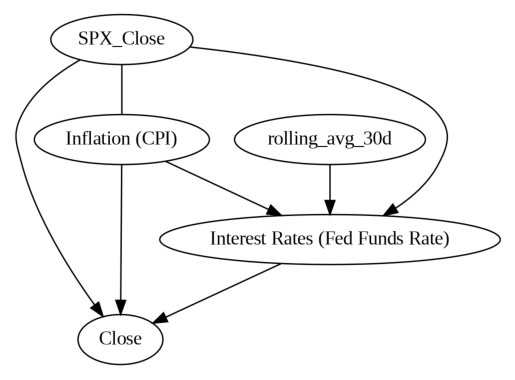

In [42]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

#create a list of column names to label the nodes in the causal graph
labels = [f'{col}' for i, col in enumerate(df.columns)]
#turn the dataframe into a numpy matrix
data = df.to_numpy()

#run the PC algorithm
cg = pc(data)


#Converts the learned graph into a pydot object
pyd = GraphUtils.to_pydot(cg.G, labels=labels)
#visualise the graph
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

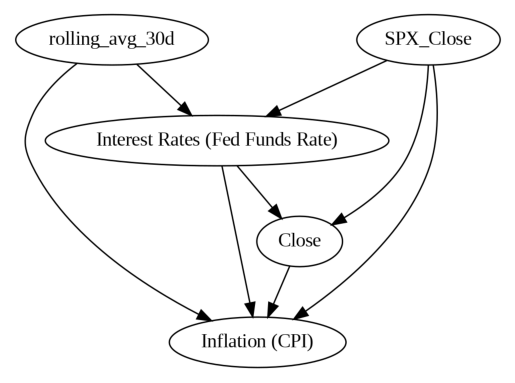

In [37]:
from causallearn.search.ScoreBased.GES import ges

#run the GES algorithm
Record = ges(data)

#Converts the learned graph into a pydot object
pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
#visualise graph
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

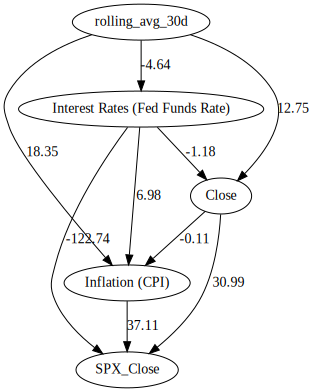

In [38]:
from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot

#create an instance of the ICA-LiNGAM class
model_lingam = lingam.ICALiNGAM()
#run lingam model
model_lingam.fit(data)

#visualise the learned graph
make_dot(model_lingam.adjacency_matrix_, labels=labels)

In [ ]:
#Define causal graph based on our own assumptions to comapre
causal_graph = """
digraph {
    Sentiment-> Stock_Close;
    SPX_Health -> Stock_Close;
}
"""

# Causal Inference

Causal inference estimates effects from a known or assumed model.

DoWhy, a widely adopted library for causal inference, applies Pearl's framework using a four-step pipeline: Model, Identify, Estimate, and Refute.

DoWhy includes a variety of built-in refutation techniques, which tests whether causal conclusions remain consistent after changes to the data or model assumptions.

Source:
*   https://www.semanticscholar.org/paper/DoWhy%3A-An-End-to-End-Library-for-Causal-Inference-Sharma-K%C4%B1c%C4%B1man/025034f4397936152ea6c77e5f7a880d5b272088






In [43]:
import warnings
#just to keep output clean
warnings.simplefilter(action='ignore', category=FutureWarning)

#convert the learned adjacency matrix from LiNGAM into a graphviz.Digraph object
graph_dot = make_graph(model_lingam.adjacency_matrix_, labels=labels)

#Define Causal Model with Dowhy
model=CausalModel(
        data = df, #cleaned numeric dataset
        treatment='rolling_avg_30d', #sentiment
        outcome='Close', #stock close price
        #convert from graphviz to dot format
        graph=str_to_dot(graph_dot.source))

#Find an estimand for the causal effect, even if full identification is not guarenteed
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

#Estimate the effect using linear regression while controlling for confounders using backdoor criterion
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                confidence_intervals=True,
                                test_significance=True)
#Print numeric estimate (e.g. a 1-point increase in sentiment causes a X change in stock price)
print("Causal Estimate is " + str(estimate))

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                   
──────────────────(E[Close])
d[rolling_avg_30d]          
Estimand assumption 1, Unconfoundedness: If U→{rolling_avg_30d} and U→Close then P(Close|rolling_avg_30d,,U) = P(Close|rolling_avg_30d,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal Estimate is *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                   
──────────────────(E[Close])
d[rolling_avg_30d]          
Estimand assumption 1, Unconfoundedness: If U→{rolling_avg_30d} and U→Close then P(Close|rolling_avg_30d,,U) = P(Close|rolling_avg_30d,)

## Realized estimand
b: Close~rolling_avg_30d
Target units: ate

## Estimate
Mean value: 18.21869792995593
p-value: [0.]
95.0% confi

Random Common Cause method adds a synthetic, independent confounder to ensure the effect estimate remains stable.

In [ ]:
refutation_random = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print("\nRefutation Test (Random Common Cause):", refutation_random)



Refutation Test (Random Common Cause): Refute: Add a random common cause
Estimated effect:18.478120008879102
New effect:18.47325350870096
p value:0.8799999999999999



Data Subset Refuter re-estimats the effect on random subsets of the data to  assess whether the causal estimate generalises across different sample splits. Large variations would suggest the effect is unstable or context-dependent.

In [ ]:
refutation_subset = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print("\nRefutation Test (Data Subset):", refutation_subset)


Refutation Test (Placebo Treatment): Refute: Use a subset of data
Estimated effect:18.478120008879102
New effect:18.362558131135945
p value:0.94



# Cross-validation with EconML
 We compare the causal estimate obtained from DoWhy with that produced by EconML, which offers alternative double machine learning (DML) based estimators. DML is a method for estimating how a treatment affects an outcome and is particularly beneficial when data is high-dimensional or the relationships between variables are too complex to be modeled with linear equations.This allows us to verify whether the identified causal effect remains consistent across different models and estimation strategies.


Sources:
*   https://econml.azurewebsites.net/_autosummary/econml.dml.DML.html
*   https://econml.azurewebsites.net/spec/estimation/dml.html



In [44]:
from econml.dml import DML
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

#again just to clean output
warnings.simplefilter(action='ignore', category=FutureWarning)

#re-load data
df = df.dropna()
#Make sure treatment and outcome are numpy arrays, then flatten it
#Y is the outcome
Y = df['Close'].to_numpy().ravel()
#T is the treatment
T = df['rolling_avg_30d'].to_numpy().ravel()


#Define confounder variables
#Drop the treatment and outcome and use the rest of the columns as confounders
covariate_cols = df.drop(columns=['Close', 'rolling_avg_30d']).columns.tolist()
X = df[covariate_cols].values

#Estimate using EconML through DoWhy's interface
econml_estimate = model.estimate_effect(
    identified_estimand, #estimating the effect of the estimand DoWhy previously identified
    method_name="backdoor.econml.dml.DML",
    method_params={
        "init_params": {
            "model_y": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0), #learn how the outcome is influenced by confounders
            "model_t": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0), #learn how the treatment is influenced by confounders
            "model_final": Lasso(alpha=0.1, fit_intercept=False), #after removing confounding influences, this model estimates the causal effect of treatment on outcome
            "cv": 3 #define the k-fold validation
        },
        "fit_params": {}
    }
)

print("\n EconML Causal Estimate:", econml_estimate.value)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



 EconML Causal Estimate: 2.8128828096274012


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
